## Problem Statement:
<p>Given a sentiment analysis data, data consist of sentences and it's sentement class, model must predict the class of the given sentence(positive or negative)</p>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix
from prettytable import PrettyTable
import nltk
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('gdrive',force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


## Loading Data

In [4]:
base_dir = 'gdrive/My Drive/project/sentiment_analysis/'
data = pd.read_csv(base_dir+'data.csv')
print('Shape of the data:',data.shape)
data.head()

Shape of the data: (8038, 2)


,sentences,label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8038 entries, 0 to 8037
Data columns (total 2 columns):
sentences    8038 non-null object
label        8038 non-null int64
dtypes: int64(1), object(1)
memory usage: 125.7+ KB


### Observations:
<ol>
    <li>Total number of rows in dataframe  is 7618</li>
    <li>There are no empty or nan cells in the dataframe</li>
    
</ol>    

## Exploratory Data Analysis

### Checking data is balanced 

In [6]:
data.label.value_counts()

1    4479
0    3559
Name: label, dtype: int64

<strong>Since this simple two class classification normal machine learning techniques are sufficient</strong>

Number of points belong to class 1  4479 , ( 55.72281662105001 %)
Number of points belong to class 0  3559 , ( 44.277183378949985 %)


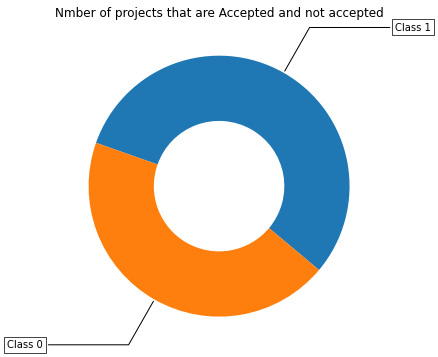

In [7]:
# CODE Ref:
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py


label_counts = data['label'].value_counts()
print("Number of points belong to class 1 ", label_counts[1], ", (", (label_counts[1]/(label_counts[1]+label_counts[0]))*100,"%)")
print("Number of points belong to class 0 ", label_counts[0], ", (", (label_counts[0]/(label_counts[1]+label_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Class 1", "Class 0"]

plt_data = [label_counts[1], label_counts[0]]

wedges, texts = ax.pie(plt_data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of projects that are Accepted and not accepted")

plt.show()

### Observations:
<ol>
    <li>There are 4479 class 1 data points and 3559 class 0 data points, i.e almost class 1 is  having 1000 data points high</li>
    <li>As class 0 is having less datapoints but not considerablly less data points we can say that the data is imbalanced</li>
    
</ol>    

## EDA
Performing eda on and making note of things to be cleaned and must not be cleaned

### EDA On Length Of sentences:

In [0]:
def dist_plot(data,col,target='label'):
        
        '''
          Given data and a column function plots the distribution plot for that column
        '''
        sns.set_style("whitegrid")
        sns.FacetGrid(data,hue='label',height=7,).map(sns.distplot,col,hist=False).add_legend()
        
        plt.show()

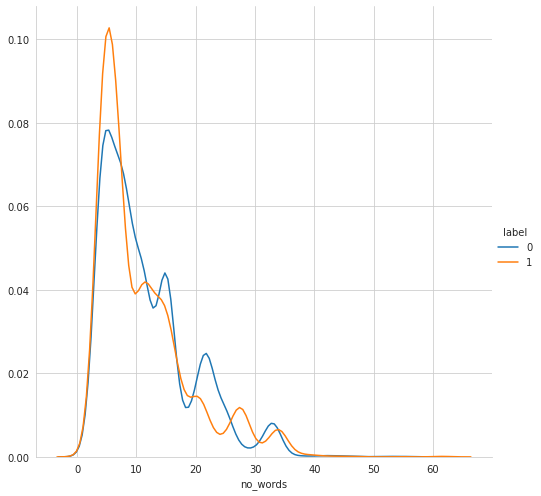

In [251]:
data['no_words'] = data.sentences.apply(lambda x:len(x.split()))

dist_plot(data,'no_words')

<h1> Is length of sentences effecting the class label?--->
Yes but very little</h1>

### EDA On Presence Of Numbers In sentences

In [0]:
number_presence = [0  for i in range(data.shape[0])] # assigning zeros with size of number of rows in data
for i in range(data.shape[0]):
     for j in data.sentences.iloc[i].split():
            if j.isdigit():
                number_presence[i] += 1 #adding that particular position with 1
            

In [0]:
data['number_presence'] = number_presence


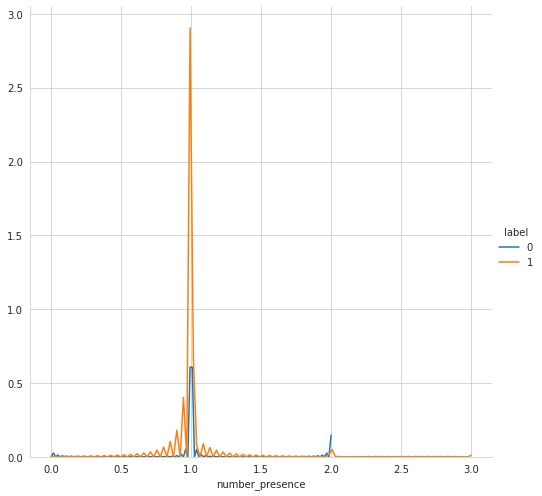

In [252]:
dist_plot(data,'number_presence')


In [253]:
print('Zero number of numbers in sentence ')
print(data[data.number_presence == 0 ].label.value_counts())
print('-'*50)
print('One number of numbers in sentence ')
print(data[data.number_presence == 1 ].label.value_counts())
print('-'*50)
print('Two number of numbers in sentence ')
print(data[data.number_presence == 2 ].label.value_counts())
print('-'*50)
print('Three number of numbers in sentence ')
print(data[data.number_presence == 3 ].label.value_counts())


Zero number of numbers in sentence 
1    4145
0    3495
Name: label, dtype: int64
--------------------------------------------------
One number of numbers in sentence 
1    327
0     59
Name: label, dtype: int64
--------------------------------------------------
Two number of numbers in sentence 
1    6
0    5
Name: label, dtype: int64
--------------------------------------------------
Three number of numbers in sentence 
1    1
Name: label, dtype: int64


<h1> Is presence of number effecting the class label? --> Yes but, only if one number is present in the sentence then it  is effecting</h1> 

### EDA On Presence Of Exclamation Mark And Question Mark

In [0]:
exc_presence = [0  for i in range(data.shape[0])]
quest_presence = [0  for i in range(data.shape[0])]

for i in range(data.shape[0]):
     for j in data.sentences.iloc[i]:
            if j == '!':
                exc_presence[i] += 1
            elif j == '?':
                quest_presence[i]+=1
data['exc_presence']   = exc_presence
data['quest_presence'] = quest_presence

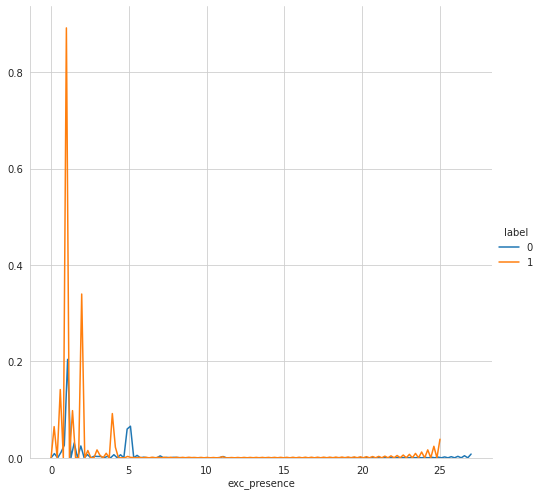

In [255]:
dist_plot(data,'exc_presence')


In [256]:
data.exc_presence.value_counts()

0     6868
1      692
2      274
4       89
5       85
3       20
11       4
7        2
27       1
25       1
9        1
8        1
Name: exc_presence, dtype: int64

In [257]:
print('Zero number of exclamation marks in sentence ')
print(data[data.exc_presence == 0 ].label.value_counts())
print('-'*50)

print('One number of exclamation marks in sentence ')
print(data[data.exc_presence == 1 ].label.value_counts())
print('-'*50)

print('Two number of exclamation marks in sentence ')
print(data[data.exc_presence == 2 ].label.value_counts())
print('-'*50)

print('Three number of exclamation marks in sentence ')
print(data[data.exc_presence == 3 ].label.value_counts())
print('-'*50)

print('Four number of exclamation marks in sentence ')
print(data[data.exc_presence == 4 ].label.value_counts())
print('-'*50)

print('Five number of exclamation marks in sentence ')
print(data[data.exc_presence == 5 ].label.value_counts())
print('-'*50)

Zero number of exclamation marks in sentence 
1    3565
0    3303
Name: label, dtype: int64
--------------------------------------------------
One number of exclamation marks in sentence 
1    541
0    151
Name: label, dtype: int64
--------------------------------------------------
Two number of exclamation marks in sentence 
1    263
0     11
Name: label, dtype: int64
--------------------------------------------------
Three number of exclamation marks in sentence 
1    16
0     4
Name: label, dtype: int64
--------------------------------------------------
Four number of exclamation marks in sentence 
1    87
0     2
Name: label, dtype: int64
--------------------------------------------------
Five number of exclamation marks in sentence 
0    82
1     3
Name: label, dtype: int64
--------------------------------------------------


<h1>Is presence of exclamation mark effecting the class label? --> Yes </h1>

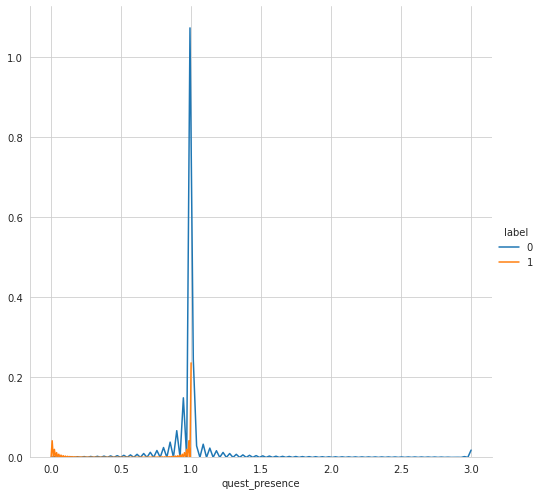

In [258]:
dist_plot(data,'quest_presence')


In [259]:
data.quest_presence.value_counts()

0    7936
1     101
3       1
Name: quest_presence, dtype: int64

In [260]:
print('Zero number of question marks in sentence ')
print(data[data.quest_presence == 0 ].label.value_counts())
print('-'*50)
print('One number of question marks in sentence ')
print(data[data.quest_presence == 1 ].label.value_counts())
print('-'*50)
print('Three number of question marks in sentence ')
print(data[data.quest_presence == 3 ].label.value_counts())


Zero number of question marks in sentence 
1    4474
0    3462
Name: label, dtype: int64
--------------------------------------------------
One number of question marks in sentence 
0    96
1     5
Name: label, dtype: int64
--------------------------------------------------
Three number of question marks in sentence 
0    1
Name: label, dtype: int64


<h1>Is presence of question mark effecting the class label? --> Yes but, only if one question mark is present </h1>

### EDA On Mean Word Lengths

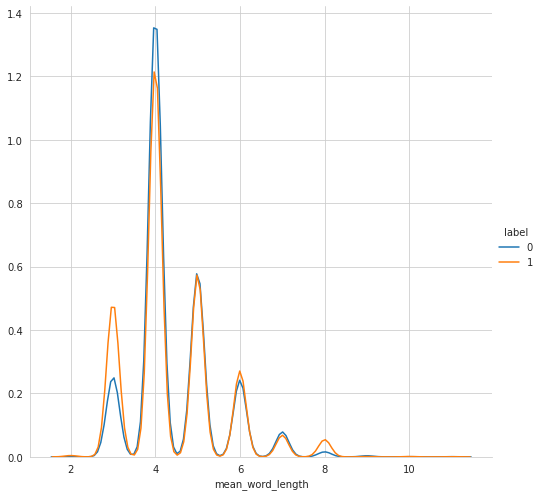

In [261]:
dist_plot(data,'mean_word_length')


In [262]:
data.mean_word_length.value_counts()

4     3995
5     1758
3     1165
6      770
7      218
8      112
2        8
9        7
10       3
11       2
Name: mean_word_length, dtype: int64

In [263]:
print('2 number of question marks in sentence ')
print(data[data.mean_word_length == 2 ].label.value_counts())
print('-'*50)
print('Three number of question marks in sentence ')
print(data[data.mean_word_length == 3 ].label.value_counts())
print('-'*50)
print('Four number of question marks in sentence ')
print(data[data.mean_word_length == 4 ].label.value_counts())
print('-'*50)

print('Five number of question marks in sentence ')
print(data[data.mean_word_length == 5 ].label.value_counts())
print('-'*50)

print('Six number of question marks in sentence ')
print(data[data.mean_word_length == 6 ].label.value_counts())
print('-'*50)

print('Seven number of question marks in sentence ')
print(data[data.mean_word_length == 7 ].label.value_counts())
print('-'*50)


2 number of question marks in sentence 
1    7
0    1
Name: label, dtype: int64
--------------------------------------------------
Three number of question marks in sentence 
1    816
0    349
Name: label, dtype: int64
--------------------------------------------------
Four number of question marks in sentence 
1    2057
0    1938
Name: label, dtype: int64
--------------------------------------------------
Five number of question marks in sentence 
1    952
0    806
Name: label, dtype: int64
--------------------------------------------------
Six number of question marks in sentence 
1    441
0    329
Name: label, dtype: int64
--------------------------------------------------
Seven number of question marks in sentence 
1    111
0    107
Name: label, dtype: int64
--------------------------------------------------


<h1> Is mean word length effecting the class label--> Yes but very little</h1>

## Cleaning Data

In [0]:
nltk.download('stopwords')
stop_words = stopwords.words('english')


In [0]:
def  clean(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can\'t", "can not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence=re.sub(r'\\r',' ',sentence)
    sentence=re.sub(r'\\n',' ',sentence)
    sentence=re.sub(r'\\b',' ',sentence)
    sentence = re.sub('[^A-Za-z0-9\!\?]+', ' ', sentence)
    # sentence=re.sub(r'nannan','',sentence)
    
    sent=[]
    for word in sentence.split():
        if (word not in stop_words) and (word.isalpha()):
            sent.append(word)
    sentence=' '.join(sent)
    return sentence

In [0]:
data['clean_sent'] = data.sentences.apply(lambda x:clean(x))

## Applying Deep Learning Models

In [0]:
import keras

In [0]:
def tokenize(text):
  tokenizer = keras.preprocessing.text.Tokenizer(
      filters='')
  tokenizer.fit_on_texts(text)

  tensor = tokenizer.texts_to_sequences(text)

  tensor = keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor

In [0]:
final_x = tokenize(data.clean_sent)

In [0]:
from scipy import sparse
from scipy.sparse import hstack,vstack
from sklearn.preprocessing import Normalizer

In [0]:
no_words_normal = Normalizer()
number_presence_normal = Normalizer()
exc_presence_normal    = Normalizer()
quest_presence_normal  = Normalizer()
mean_word_len_normal   = Normalizer()


In [0]:
final_x = hstack((sparse.csr_matrix(final_x),
                  sparse.csr_matrix(no_words_normal.fit_transform(data.no_words.values.reshape(-1,1))),
                  sparse.csr_matrix(number_presence_normal.fit_transform(data.number_presence.values.reshape(-1,1))),
                  sparse.csr_matrix(exc_presence_normal.fit_transform(data.exc_presence.values.reshape(-1,1))),
                  sparse.csr_matrix(quest_presence_normal.fit_transform(data.quest_presence.values.reshape(-1,1))),
                  sparse.csr_matrix(mean_word_len_normal.fit_transform(data.mean_word_length.values.reshape(-1,1)))
                  
                  ))

## Splitting Data

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [277]:
multiclass = MultiLabelBinarizer()
multiclass.fit(data.label.apply(lambda x: 'p' if x == 1 else 'n'))
multiclass.classes_

array(['n', 'p'], dtype=object)

In [278]:
y = multiclass.transform(data.label.apply(lambda x: 'p' if x == 1 else 'n'))


x_train,x_test,y_train,y_test  = train_test_split(final_x,y,test_size=0.3)



print('Shape of train data:',x_train.shape)
print('Shape of test  data:',x_test.shape)


Shape of train data: (5626, 41)
Shape of test  data: (2412, 41)


### Applying ANN

In [279]:
embedding_dim = 256
units = 1024
vocab_size = len(tokenizer_x.word_index)+1

ann_model = keras.Sequential()
ann_model.add(keras.layers.Embedding(vocab_size,embedding_dim))
ann_model.add(keras.layers.Dense(units=30,activation='relu'))
ann_model.add(keras.layers.BatchNormalization())
ann_model.add(keras.layers.Dropout(0.2))
ann_model.add(keras.layers.Dense(units=30,activation='relu'))
ann_model.add(keras.layers.BatchNormalization())
ann_model.add(keras.layers.Dropout(0.3))
ann_model.add(keras.layers.Dense(units=2,activation='relu'))
ann_model.add(keras.layers.Activation(activation='sigmoid'))

ann_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 256)         1015552   
_________________________________________________________________
dense_34 (Dense)             (None, None, 30)          7710      
_________________________________________________________________
batch_normalization_17 (Batc (None, None, 30)          120       
_________________________________________________________________
dropout_22 (Dropout)         (None, None, 30)          0         
_________________________________________________________________
dense_35 (Dense)             (None, None, 30)          930       
_________________________________________________________________
batch_normalization_18 (Batc (None, None, 30)          120       
_________________________________________________________________
dropout_23 (Dropout)         (None, None, 30)        

In [280]:
ann_model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
ann_history = ann_model.fit(x_train,y_train.reshape(5626,1,2),epochs=10,validation_split=0.2)
 

Train on 4500 samples, validate on 1126 samples
Epoch 1/10
4500/4500 [==============================] - 7s 2ms/step - loss: 0.6795 - acc: 0.4972 - val_loss: 0.6728 - val_acc: 0.4901
Epoch 2/10
4500/4500 [==============================] - 3s 744us/step - loss: 0.6716 - acc: 0.5225 - val_loss: 0.6691 - val_acc: 0.5964
Epoch 3/10
4500/4500 [==============================] - 5s 1ms/step - loss: 0.6690 - acc: 0.5579 - val_loss: 0.6659 - val_acc: 0.5964
Epoch 4/10
4500/4500 [==============================] - 5s 1ms/step - loss: 0.6667 - acc: 0.5864 - val_loss: 0.6671 - val_acc: 0.5970
Epoch 5/10
4500/4500 [==============================] - 5s 1ms/step - loss: 0.6664 - acc: 0.5919 - val_loss: 0.6652 - val_acc: 0.5971
Epoch 6/10
4500/4500 [==============================] - 5s 1ms/step - loss: 0.6653 - acc: 0.5923 - val_loss: 0.6679 - val_acc: 0.5978
Epoch 7/10
4500/4500 [==============================] - 5s 1ms/step - loss: 0.6653 - acc: 0.5922 - val_loss: 0.6647 - val_acc: 0.5967
Epoch 8/10
4

In [281]:
ann_model.evaluate(x_test,y_test.reshape(2412,1,2))

2412/2412 [==============================] - 0s 200us/step


[0.6655715801822606, 0.5947194944566755]

<h2>Normal ANN is giving only 59% of accuracy</h2>

### Applying CNN

In [282]:
cnn_model = keras.Sequential()
cnn_model.add(keras.layers.Embedding(vocab_size,embedding_dim))
cnn_model.add(keras.layers.Conv1D(10,3,activation='relu',strides=1))
cnn_model.add(keras.layers.Dropout(0.5))
cnn_model.add(keras.layers.MaxPool1D())
cnn_model.add(keras.layers.Dense(2))
cnn_model.add(keras.layers.Activation('sigmoid'))

cnn_model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 256)         1015552   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 10)          7690      
_________________________________________________________________
dropout_24 (Dropout)         (None, None, 10)          0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 10)          0         
_________________________________________________________________
dense_37 (Dense)             (None, None, 2)           22        
_________________________________________________________________
activation_19 (Activation)   (None, None, 2)           0         
Total params: 1,023,264
Trainable params: 1,023,264
Non-trainable params: 0
___________________________________________

In [283]:
cnn_model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
cnn_history = cnn_model.fit(x_train,y_train.reshape(5626,1,2),epochs=10,validation_split=0.2)
 

Train on 4500 samples, validate on 1126 samples
Epoch 1/10
4500/4500 [==============================] - 11s 2ms/step - loss: 0.6540 - acc: 0.5977 - val_loss: 0.6146 - val_acc: 0.6245
Epoch 2/10
4500/4500 [==============================] - 5s 1ms/step - loss: 0.6046 - acc: 0.6215 - val_loss: 0.6035 - val_acc: 0.6276
Epoch 3/10
4500/4500 [==============================] - 6s 1ms/step - loss: 0.5932 - acc: 0.6267 - val_loss: 0.6038 - val_acc: 0.6291
Epoch 4/10
4500/4500 [==============================] - 6s 1ms/step - loss: 0.5869 - acc: 0.6293 - val_loss: 0.6051 - val_acc: 0.6285
Epoch 5/10
4500/4500 [==============================] - 6s 1ms/step - loss: 0.5833 - acc: 0.6307 - val_loss: 0.6080 - val_acc: 0.6287
Epoch 6/10
4500/4500 [==============================] - 5s 1ms/step - loss: 0.5814 - acc: 0.6315 - val_loss: 0.6119 - val_acc: 0.6284
Epoch 7/10
4500/4500 [==============================] - 6s 1ms/step - loss: 0.5797 - acc: 0.6317 - val_loss: 0.6135 - val_acc: 0.6289
Epoch 8/10
45

In [284]:
cnn_model.evaluate(x_test,y_test.reshape(2412,1,2))

2412/2412 [==============================] - 1s 257us/step


[0.6188217474651179, 0.6288949957929836]

<h2>CNN model  is giving 62% accuracy which is better than the ANN model</h2>

### Applying RNN

In [290]:
rnn_model = keras.Sequential()
rnn_model.add(keras.layers.Embedding(vocab_size,embedding_dim))
rnn_model.add(keras.layers.GRU(5,return_sequences=True))


rnn_model.add(keras.layers.Dense(2))
rnn_model.add(keras.layers.Activation('sigmoid'))

rnn_model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, None, 256)         1015552   
_________________________________________________________________
gru_6 (GRU)                  (None, None, 5)           3930      
_________________________________________________________________
dense_39 (Dense)             (None, None, 2)           12        
_________________________________________________________________
activation_21 (Activation)   (None, None, 2)           0         
Total params: 1,019,494
Trainable params: 1,019,494
Non-trainable params: 0
_________________________________________________________________


In [291]:
rnn_model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
rnn_history = rnn_model.fit(x_train,y_train.reshape(5626,1,2),epochs=10,validation_split=0.2,batch_size=30)
 

Train on 4500 samples, validate on 1126 samples
Epoch 1/10
4500/4500 [==============================] - 11s 2ms/step - loss: 0.6118 - acc: 0.6592 - val_loss: 0.3282 - val_acc: 0.9084
Epoch 2/10
4500/4500 [==============================] - 7s 1ms/step - loss: 0.2073 - acc: 0.9499 - val_loss: 0.1982 - val_acc: 0.9324
Epoch 3/10
4500/4500 [==============================] - 7s 1ms/step - loss: 0.1119 - acc: 0.9743 - val_loss: 0.1783 - val_acc: 0.9360
Epoch 4/10
4500/4500 [==============================] - 7s 2ms/step - loss: 0.0784 - acc: 0.9810 - val_loss: 0.1781 - val_acc: 0.9335
Epoch 5/10
4500/4500 [==============================] - 7s 2ms/step - loss: 0.0631 - acc: 0.9831 - val_loss: 0.1770 - val_acc: 0.9347
Epoch 6/10
4500/4500 [==============================] - 7s 1ms/step - loss: 0.0541 - acc: 0.9844 - val_loss: 0.1835 - val_acc: 0.9332
Epoch 7/10
4500/4500 [==============================] - 7s 1ms/step - loss: 0.0484 - acc: 0.9850 - val_loss: 0.1877 - val_acc: 0.9342
Epoch 8/10
45

In [292]:
rnn_model.evaluate(x_test,y_test.reshape(2412,1,2))

2412/2412 [==============================] - 1s 240us/step


[0.1987335584427587, 0.9291044752396161]

<h2>Accuracy of the RNN model is 92% which far better than CNN and ANN models</h2>